# rs101_limitexample
Limits: number counting experiment with uncertainty on both the background rate and signal efficiency.

The usage of a Confidence Interval Calculator to set a limit on the signal is illustrated




**Author:**  Artem Busorgin, Kyle Cranmer (C++ version)  
<i><small>This notebook tutorial was automatically generated with <a href= "https://github.com/root-project/root/blob/master/documentation/doxygen/converttonotebook.py">ROOTBOOK-izer</a> from the macro found in the ROOT repository  on Wednesday, April 17, 2024 at 11:20 AM.</small></i>

In [1]:
import ROOT

--------------------------------------
An example of setting a limit in a number counting experiment with uncertainty on background and signal

to time the macro

In [2]:
t = ROOT.TStopwatch()
t.Start()

--------------------------------------
The Model building stage
--------------------------------------

In [3]:
wspace = ROOT.RooWorkspace()
wspace.factory(
    "Poisson::countingModel(obs[150,0,300], " "sum(s[50,0,120]*ratioSigEff[1.,0,3.],b[100]*ratioBkgEff[1.,0.,3.]))"
)  # counting model
wspace.factory("Gaussian::sigConstraint(gSigEff[1,0,3],ratioSigEff,0.05)")  # 5% signal efficiency uncertainty
wspace.factory("Gaussian::bkgConstraint(gSigBkg[1,0,3],ratioBkgEff,0.2)")  # 10% background efficiency uncertainty
wspace.factory("PROD::modelWithConstraints(countingModel,sigConstraint,bkgConstraint)")  # product of terms
wspace.Print()

modelWithConstraints = wspace["modelWithConstraints"]  # get the model
obs = wspace["obs"]  # get the observable
s = wspace["s"]  # get the signal we care about
b = wspace["b"]  # get the background and set it to a constant.  Uncertainty included in ratioBkgEff
b.setConstant()

ratioSigEff = wspace["ratioSigEff"]  # get uncertain parameter to constrain
ratioBkgEff = wspace["ratioBkgEff"]  # get uncertain parameter to constrain
constrainedParams = {ratioSigEff, ratioBkgEff}  # need to constrain these in the fit (should change default behavior)

gSigEff = wspace["gSigEff"]  # global observables for signal efficiency
gSigBkg = wspace["gSigBkg"]  # global obs for background efficiency
gSigEff.setConstant()
gSigBkg.setConstant()


RooWorkspace()  contents

variables
---------
(b,gSigBkg,gSigEff,obs,ratioBkgEff,ratioSigEff,s)

p.d.f.s
-------
RooGaussian::bkgConstraint[ x=gSigBkg mean=ratioBkgEff sigma=0.2 ] = 1
RooPoisson::countingModel[ x=obs mean=countingModel_2 ] = 0.0325554
RooProdPdf::modelWithConstraints[ countingModel * sigConstraint * bkgConstraint ] = 0.0325554
RooGaussian::sigConstraint[ x=gSigEff mean=ratioSigEff sigma=0.05 ] = 1

functions
--------
RooAddition::countingModel_2[ countingModel_2_[s_x_ratioSigEff] + countingModel_2_[b_x_ratioBkgEff] ] = 150
RooProduct::countingModel_2_[b_x_ratioBkgEff][ b * ratioBkgEff ] = 100
RooProduct::countingModel_2_[s_x_ratioSigEff][ s * ratioSigEff ] = 50



Create an example dataset with 160 observed events

In [4]:
obs.setVal(160.0)
dataOrig = ROOT.RooDataSet("exampleData", "exampleData", {obs})
dataOrig.add(obs)

not necessary

In [5]:
modelWithConstraints.fitTo(dataOrig, Constrain=constrainedParams, PrintLevel=-1)

<cppyy.gbl.RooFitResult object at 0x(nil)>

[#1] INFO:Minimization --  Including the following constraint terms in minimization: (sigConstraint,bkgConstraint)
[#1] INFO:Minimization -- The global observables are not defined , normalize constraints with respect to the parameters (ratioBkgEff,ratioSigEff)
[#1] INFO:Fitting -- RooAbsPdf::fitTo(modelWithConstraints) fixing normalization set for coefficient determination to observables in data
[#1] INFO:Fitting -- using CPU computation library compiled with -mavx2
[#1] INFO:Fitting -- RooAddition::defaultErrorLevel(nll_modelWithConstraints_exampleData) Summation contains a RooNLLVar, using its error level
[#1] INFO:Minimization -- RooAbsMinimizerFcn::setOptimizeConst: activating const optimization
[#1] INFO:Minimization -- RooAbsMinimizerFcn::setOptimizeConst: deactivating const optimization


Now let's make some confidence intervals for s, our parameter of interest

In [6]:
modelConfig = ROOT.RooStats.ModelConfig(wspace)
modelConfig.SetPdf(modelWithConstraints)
modelConfig.SetParametersOfInterest({s})
modelConfig.SetNuisanceParameters(constrainedParams)
modelConfig.SetObservables(obs)
modelConfig.SetGlobalObservables({gSigEff, gSigBkg})
modelConfig.SetName("ModelConfig")
wspace.Import(modelConfig)
wspace.Import(dataOrig)
wspace.SetName("w")
wspace.writeToFile("rs101_ws.root")

False

[#1] INFO:ObjectHandling -- RooWorkspace::import() importing dataset exampleData


Make sure we reference the data in the workspace from now on

In [7]:
data = wspace[dataOrig.GetName()]

First, let's use a Calculator based on the Profile Likelihood Ratio

In [8]:
plc = ROOT.RooStats.ProfileLikelihoodCalculator(data, modelConfig)
plc.SetTestSize(0.05)
lrinterval = plc.GetInterval()

[#1] INFO:InputArguments -- The deprecated RooFit::CloneData(1) option passed to createNLL() is ignored.
[#1] INFO:Minimization --  Including the following constraint terms in minimization: (sigConstraint,bkgConstraint)
[#1] INFO:Minimization -- The following global observables have been defined and their values are taken from the model: (gSigEff,gSigBkg)
[#1] INFO:Fitting -- RooAbsPdf::fitTo(modelWithConstraints) fixing normalization set for coefficient determination to observables in data
[#0] PROGRESS:Minimization -- ProfileLikelihoodCalcultor::DoGLobalFit - find MLE 
[#1] INFO:Fitting -- RooAddition::defaultErrorLevel(nll_modelWithConstraints_exampleData) Summation contains a RooNLLVar, using its error level
[#1] INFO:Minimization -- RooAbsMinimizerFcn::setOptimizeConst: activating const optimization
[#0] PROGRESS:Minimization -- ProfileLikelihoodCalcultor::DoMinimizeNLL - using Minuit2 / Migrad with strategy 1
[#1] INFO:Minimization -- 
  RooFitResult: minimized FCN value: 0.68975

Let's make a plot

In [9]:
dataCanvas = ROOT.TCanvas("dataCanvas")
dataCanvas.Divide(2, 1)
dataCanvas.cd(1)

plotInt = ROOT.RooStats.LikelihoodIntervalPlot(lrinterval)
plotInt.SetTitle("Profile Likelihood Ratio and Posterior for S")
plotInt.Draw()

[#1] INFO:Minimization -- RooProfileLL::evaluate(RooEvaluatorWrapper_Profile[s]) Creating instance of MINUIT
[#1] INFO:Fitting -- RooAddition::defaultErrorLevel(nll_modelWithConstraints_exampleData) Summation contains a RooNLLVar, using its error level
[#1] INFO:Minimization -- RooProfileLL::evaluate(RooEvaluatorWrapper_Profile[s]) determining minimum likelihood for current configurations w.r.t all observable
[#1] INFO:Minimization -- RooProfileLL::evaluate(RooEvaluatorWrapper_Profile[s]) minimum found at (s=60)
.
[#1] INFO:Minimization -- RooProfileLL::evaluate(RooEvaluatorWrapper_Profile[s]) Creating instance of MINUIT
[#1] INFO:Fitting -- RooAddition::defaultErrorLevel(nll_modelWithConstraints_exampleData) Summation contains a RooNLLVar, using its error level
[#1] INFO:Minimization -- RooProfileLL::evaluate(RooEvaluatorWrapper_Profile[s]) determining minimum likelihood for current configurations w.r.t all observable
[#0] ERROR:InputArguments -- RooArgSet::checkForDup: ERROR argument

Second, use a Calculator based on the Feldman Cousins technique

In [10]:
fc = ROOT.RooStats.FeldmanCousins(data, modelConfig)
fc.UseAdaptiveSampling(True)
fc.FluctuateNumDataEntries(False)  # number counting analysis: dataset always has 1 entry with N events observed
fc.SetNBins(100)  # number of points to test per parameter
fc.SetTestSize(0.05)

fc.SaveBeltToFile(True) # optional

In [11]:
fcint = fc.GetInterval()

fit = modelWithConstraints.fitTo(data, Save=True, PrintLevel=-1)


=== Using the following for ModelConfig ===
Observables:             RooArgSet:: = (obs)
Parameters of Interest:  RooArgSet:: = (s)
Nuisance Parameters:     RooArgSet:: = (ratioBkgEff,ratioSigEff)
Global Observables:      RooArgSet:: = (gSigEff,gSigBkg)
PDF:                     RooProdPdf::modelWithConstraints[ countingModel * sigConstraint * bkgConstraint ] = 0.0036613

FeldmanCousins: ntoys per point: adaptive
FeldmanCousins: nEvents per toy will not fluctuate, will always be 1
FeldmanCousins: Model has nuisance parameters, will do profile construction
FeldmanCousins: # points to test = 100
NeymanConstruction: Prog: 1/100 total MC = 80 this test stat = 3.21178
 s=0.6 ratioBkgEff=1.43644 ratioSigEff=0.999975 [-inf, 4.68588]  in interval = 1

NeymanConstruction: Prog: 2/100 total MC = 80 this test stat = 3.08184
 s=1.8 ratioBkgEff=1.42694 ratioSigEff=1.00018 [-inf, 3.7189]  in interval = 1

NeymanConstruction: Prog: 3/100 total MC = 80 this test stat = 2.95515
 s=3 ratioBkgEff=1.41769

Third, use a Calculator based on Markov Chain monte carlo
Before configuring the calculator, let's make a ProposalFunction
that will achieve a high acceptance rate

In [12]:
ph = ROOT.RooStats.ProposalHelper()
ph.SetVariables(fit.floatParsFinal())
ph.SetCovMatrix(fit.covarianceMatrix())
ph.SetUpdateProposalParameters(True)
ph.SetCacheSize(100)
pdfProp = ph.GetProposalFunction()

mc = ROOT.RooStats.MCMCCalculator(data, modelConfig)
mc.SetNumIters(20000)  # steps to propose in the chain
mc.SetTestSize(0.05)  # 95% CL
mc.SetNumBurnInSteps(40)  # ignore first N steps in chain as "burn in"
mc.SetProposalFunction(pdfProp)
mc.SetLeftSideTailFraction(0.5)  # find a "central" interval
mcInt = mc.GetInterval()

[#1] INFO:Minimization --  Including the following constraint terms in minimization: (sigConstraint,bkgConstraint)
[#1] INFO:Minimization -- The following global observables have been defined and their values are taken from the model: (gSigEff,gSigBkg)
[#1] INFO:Fitting -- RooAbsPdf::fitTo(modelWithConstraints) fixing normalization set for coefficient determination to observables in data
Metropolis-Hastings progress: ....................................................................................................
[#1] INFO:Eval -- Proposal acceptance rate: 48.15%
[#1] INFO:Eval -- Number of steps in chain: 9630


Get Lower and Upper limits from Profile Calculator

In [13]:
print("Profile lower limit on s = ", lrinterval.LowerLimit(s))
print("Profile upper limit on s = ", lrinterval.UpperLimit(s))

Profile lower limit on s =  13.949738060154317
Profile upper limit on s =  107.9503617757897


Get Lower and Upper limits from FeldmanCousins with profile construction

FC lower limit on s =  0.6
FC upper limit on s =  119.39999999999999


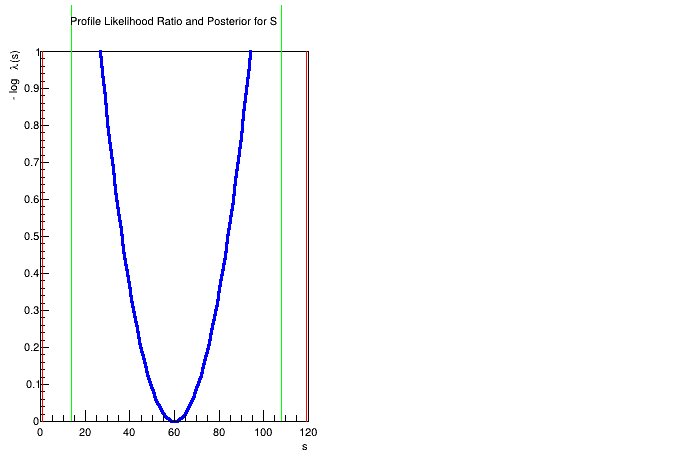

In [14]:
if fcint:
    fcul = fcint.UpperLimit(s)
    fcll = fcint.LowerLimit(s)
    print("FC lower limit on s = ", fcll)
    print("FC upper limit on s = ", fcul)
    fcllLine = ROOT.TLine(fcll, 0, fcll, 1)
    fculLine = ROOT.TLine(fcul, 0, fcul, 1)
    fcllLine.SetLineColor(ROOT.kRed)
    fculLine.SetLineColor(ROOT.kRed)
    fcllLine.Draw("same")
    fculLine.Draw("same")
    dataCanvas.Update()

Plot MCMC interval and print some statistics

In [15]:
mcPlot = ROOT.RooStats.MCMCIntervalPlot(mcInt)
mcPlot.SetLineColor(ROOT.kMagenta)
mcPlot.SetLineWidth(2)
mcPlot.Draw("same")

mcul = mcInt.UpperLimit(s)
mcll = mcInt.LowerLimit(s)
print("MCMC lower limit on s = ", mcll)
print("MCMC upper limit on s = ", mcul)
print("MCMC Actual confidence level: ", mcInt.GetActualConfidenceLevel())

MCMC lower limit on s =  19.16837376625842
MCMC upper limit on s =  103.15897826304688
MCMC Actual confidence level:  0.9499146843320285


3-d plot of the parameter points

In [16]:
dataCanvas.cd(2)

also plot the points in the markov chain

In [17]:
chainData = mcInt.GetChainAsDataSet()

print("plotting the chain data - nentries = ", chainData.numEntries())
chain = ROOT.RooStats.GetAsTTree("chainTreeData", "chainTreeData", chainData)
chain.SetMarkerStyle(6)
chain.SetMarkerColor(ROOT.kRed)

chain.Draw("s:ratioSigEff:ratioBkgEff", "nll_MarkovChain_local_", "box")  # 3-d box proportional to posterior

plotting the chain data - nentries =  9630


9630

the points used in the profile construction

In [18]:
parScanData = fc.GetPointsToScan()
print("plotting the scanned points used in the frequentist construction - npoints = ", parScanData.numEntries())

gr = ROOT.TGraph2D(parScanData.numEntries())
for ievt in range(parScanData.numEntries()):
    evt = parScanData.get(ievt)
    x = evt.getRealValue("ratioBkgEff")
    y = evt.getRealValue("ratioSigEff")
    z = evt.getRealValue("s")
    gr.SetPoint(ievt, x, y, z)

gr.SetMarkerStyle(24)
gr.Draw("P SAME")

plotting the scanned points used in the frequentist construction - npoints =  100


print timing info

In [19]:
t.Stop()
t.Print()

dataCanvas.SaveAs("rs101_limitexample.png")

Real time 0:00:20, CP time 17.630


Warning in <TAxis::TAxis::SetRangeUser>: ufirst < fXmin, fXmin is used
Warning in <TAxis::TAxis::SetRangeUser>: ulast > fXmax, fXmax is used
Warning in <TAxis::TAxis::SetRangeUser>: ufirst < fXmin, fXmin is used
Warning in <TAxis::TAxis::SetRangeUser>: ulast > fXmax, fXmax is used
Warning in <TAxis::TAxis::SetRangeUser>: ufirst < fXmin, fXmin is used
Warning in <TAxis::TAxis::SetRangeUser>: ulast > fXmax, fXmax is used
Warning in <TAxis::TAxis::SetRangeUser>: ufirst < fXmin, fXmin is used
Warning in <TAxis::TAxis::SetRangeUser>: ulast > fXmax, fXmax is used
Info in <TCanvas::Print>: png file rs101_limitexample.png has been created


Draw all canvases 

Warning in <TAxis::TAxis::SetRangeUser>: ufirst < fXmin, fXmin is used
Warning in <TAxis::TAxis::SetRangeUser>: ulast > fXmax, fXmax is used
Warning in <TAxis::TAxis::SetRangeUser>: ufirst < fXmin, fXmin is used
Warning in <TAxis::TAxis::SetRangeUser>: ulast > fXmax, fXmax is used


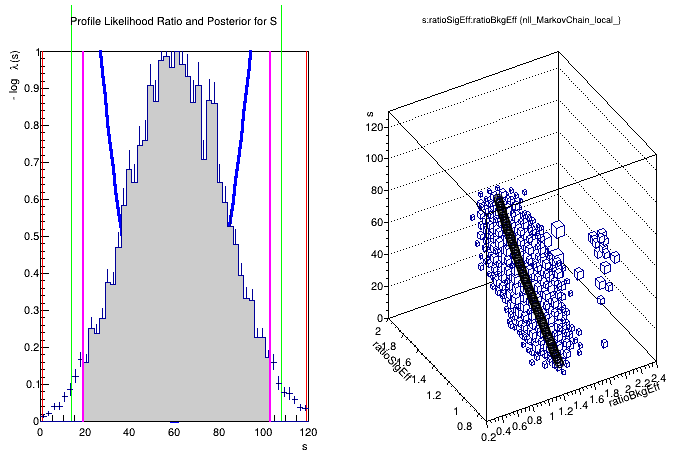

In [20]:
from ROOT import gROOT 
gROOT.GetListOfCanvases().Draw()